In [1]:
import pandas as pd
# import wget

# download data jika belum punya datanya
# wget.download('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_telemetry.csv')
# wget.download('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_errors.csv')
# wget.download('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_maint.csv')
# wget.download('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_failures.csv')
# wget.download('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_machines.csv')

# baca data hasil download
telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

In [2]:
telemetry.info()
errors.info()
maint.info()
failures.info()
machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
datetime     876100 non-null object
machineID    876100 non-null int64
volt         876100 non-null float64
rotate       876100 non-null float64
pressure     876100 non-null float64
vibration    876100 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null object
machineID    3919 non-null int64
errorID      3919 non-null object
dtypes: int64(1), object(2)
memory usage: 91.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
datetime     3286 non-null object
machineID    3286 non-null int64
comp         3286 non-null object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 

In [3]:
# konversi type data object ke type data yang sesuai
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format='%Y-%m-%d %H:%M:%S')
errors['datetime'] = pd.to_datetime(errors['datetime'], format='%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')
maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')
machines['model'] = machines['model'].astype('category')
failures['datetime'] = pd.to_datetime(failures['datetime'], format='%Y-%m-%d %H:%M:%S')
failures['failure'] = failures['failure'].astype('category')

In [4]:
telemetry.info()
errors.info()
maint.info()
failures.info()
machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
datetime     876100 non-null datetime64[ns]
machineID    876100 non-null int64
volt         876100 non-null float64
rotate       876100 non-null float64
pressure     876100 non-null float64
vibration    876100 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 40.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null datetime64[ns]
machineID    3919 non-null int64
errorID      3919 non-null category
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 65.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
datetime     3286 non-null datetime64[ns]
machineID    3286 non-null int64
comp         3286 non-null category
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 54.8 KB
<class 'pandas.co

### Feature Engineering
- Data yang disertai timestamps cocok untuk diterapkan lagging features. Sehingga akan dilakukan feature extraction berupa rolling-mean, rolling-standard deviation dengan rentang waktu tiap 3 jam dan 24 jam.
- Data error memiliki karakter yang sama dengan telemetry yang memiliki timestamps, sehingga juga dapat dilakukan extraction berupa rolling-count dengan rentang waktu 3 jam dan 24 jam.

In [5]:
# rolling mean
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry, index='datetime', columns='machineID', values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)
telemetry_mean_3h.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [6]:
# rolling std
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry, index='datetime', columns='machineID', values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_std_3h = pd.concat(temp, axis=1)
telemetry_std_3h.columns = [i + 'std_3h' for i in fields]
telemetry_std_3h.reset_index(inplace=True)
telemetry_std_3h.head()

,machineID,datetime,voltstd_3h,rotatestd_3h,pressurestd_3h,vibrationstd_3h
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,14.752132,47.048609,4.244158,2.207884


In [7]:
# rolling mean 24 jam
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.DataFrame.rolling(pd.pivot_table(telemetry, index='datetime', columns='machineID', values=col), window=24, center=False).mean().resample('3H', closed='left', label='right').first().unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]
telemetry_mean_24h.head()

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214


In [8]:
# rolling std 24 jam
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.DataFrame.rolling(pd.pivot_table(telemetry, index='datetime', columns='machineID', values=col), window=24, center=False).std().resample('3H', closed='left', label='right').first().unstack())
telemetry_std_24h = pd.concat(temp, axis=1)
telemetry_std_24h.columns = [i + 'std_24h' for i in fields]
telemetry_std_24h.reset_index(inplace=True)
telemetry_std_24h = telemetry_std_24h.loc[-telemetry_std_24h['voltstd_24h'].isnull()]
telemetry_std_24h.head()

,machineID,datetime,voltstd_24h,rotatestd_24h,pressurestd_24h,vibrationstd_24h
7,1,2015-01-02 06:00:00,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,13.954518,43.490234,8.061653,5.898069


In [9]:
telemetry_feat = pd.concat([telemetry_mean_3h, telemetry_std_3h.iloc[:, 2:6], telemetry_mean_24h.iloc[:, 2:6], telemetry_std_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltstd_3h,rotatestd_3h,pressurestd_3h,vibrationstd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltstd_24h,rotatestd_24h,pressurestd_24h,vibrationstd_24h
count,291300.00000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,170.771416,446.612973,100.855301,40.384328,13.299858,44.456335,8.885822,4.440660,170.772579,446.613440,100.854547,40.384564,14.918849,49.947916,10.046687,5.002065
std,28.86612,9.497201,33.122865,7.408854,3.476641,6.966647,23.216421,4.656341,2.320066,4.716970,18.074248,4.733098,2.059861,2.260726,7.682126,1.713726,0.799820
min,1.00000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.75000,164.445576,427.568132,96.238173,38.147839,8.027455,26.903567,5.370647,2.684308,168.070890,441.549802,98.668589,39.354062,13.358663,44.668824,8.924317,4.460347
50%,50.50000,170.430790,448.385564,100.233139,40.146085,12.495595,41.795700,8.345785,4.173854,170.210913,449.212554,100.097694,40.072752,14.853948,49.613807,9.921407,4.958594
75%,75.25000,176.607051,468.447680,104.404520,42.227392,17.689118,59.103715,11.789645,5.898997,172.459612,456.368008,101.611121,40.833364,16.394764,54.821318,10.980498,5.484480
max,100.00000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783


In [10]:
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count.head()

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0


In [11]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0


In [12]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.DataFrame.rolling(pd.pivot_table(error_count, index='datetime', columns='machineID', values=col), window=24, center=False).sum().resample('3H', closed='left', label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


### Days since last replacement
Sebagai referensi prediksi RUL, lakukan perhitungan TTF pada masing-masing komponen

In [13]:
import numpy as np
from datetime import datetime, timedelta

# siapkan dataset penggantian komponen/sparepart pada maintenance
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# masukan timepoint yang sama pada telemetry, dan replace nilai NaN dengan 0
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep, on=['datetime', 'machineID'], how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # mengganti penggantian komponen dengan tanggalnya
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    # forward-fill
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
    comp_rep[comp] = pd.to_datetime(comp_rep[comp])
    # cek lama komponen bertahan
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


### Final Feature
Penggabungan dari feature diatas dengan data mesin

In [14]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')
final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltstd_3h,rotatestd_3h,pressurestd_3h,vibrationstd_3h,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18


In [15]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features['failure'] = labeled_features['failure'].astype('object')
labeled_features['failure'] = labeled_features['failure'].fillna(method='bfill', limit=7)
labeled_features['failure'] = labeled_features['failure'].fillna('none')
labeled_features['failure'] = labeled_features['failure'].astype('category')
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltstd_3h,rotatestd_3h,pressurestd_3h,vibrationstd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none


### Build the model

In [16]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# from sklearn.model_selection import train_test_split
from IPython.display import SVG, display
from graphviz import Source

In [17]:
labeled_features.columns

Index(['machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltstd_3h', 'rotatestd_3h',
       'pressurestd_3h', 'vibrationstd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltstd_24h', 'rotatestd_24h',
       'pressurestd_24h', 'vibrationstd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'model', 'age', 'failure'],
      dtype='object')

In [18]:
col = ['machineID', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltstd_3h', 'rotatestd_3h',
       'pressurestd_3h', 'vibrationstd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltstd_24h', 'rotatestd_24h',
       'pressurestd_24h', 'vibrationstd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'age']
# membuat split train data dan test data
X_train = labeled_features.loc[0:195198, col]
X_test = labeled_features.loc[195199:, col]
y_train = labeled_features.loc[0:195198, 'failure']
y_test = labeled_features.loc[195199:, 'failure']

In [19]:
tree_model_one = tree.DecisionTreeClassifier()
tree_model_one = tree_model_one.fit(X_train.values, y_train.values)
tree_model_one.score(X_train.values, y_train.values)

0.9998463106880671

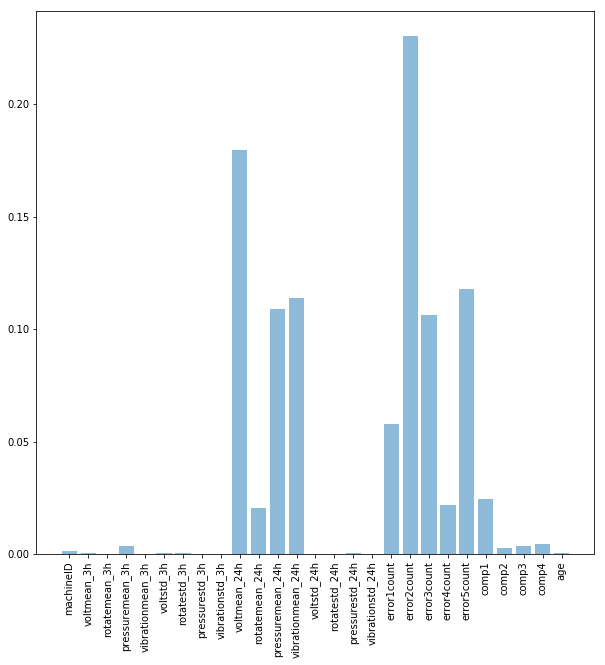

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,10))
feat_perform = tree_model_one.feature_importances_
plt.bar(col, feat_perform, align='center', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

Dari feature_importance_ dapat diketahui feature apa saja yang berpengaruh terhadap prediksi. Dibuatlah col2 dengan feature yang berbeda, mengikuti hasil dari feature_importance_

In [21]:
col2 = ['voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4']
X_train2 = labeled_features.loc[0:195198, col2]
X_test2 = labeled_features.loc[195199:, col2]
y_train2 = labeled_features.loc[0:195198, 'failure']
y_test2 = labeled_features.loc[195199:, 'failure']

In [22]:
tree_model_two = tree.DecisionTreeClassifier()
tree_model_two = tree_model_two.fit(X_train2.values, y_train2.values)

In [23]:
# Bandingkan dua score
tree_model_one.score(X_train.values, y_train.values)

0.9998463106880671

In [24]:
tree_model_two.score(X_train2.values, y_train2.values)

0.9998463106880671

Feature mengikuti hasil dari hasil feature_importance saja

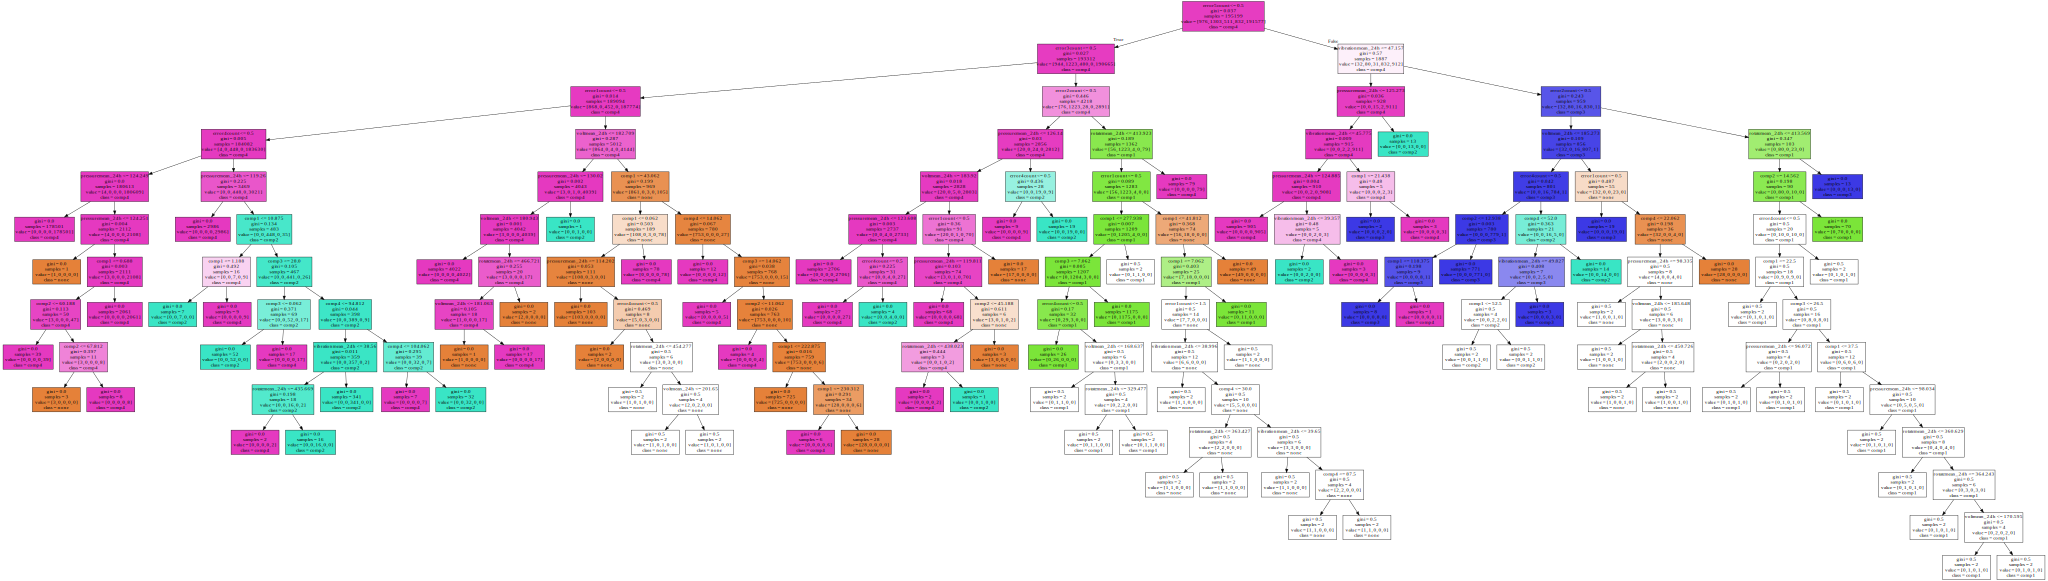

In [25]:
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'
tree_model_two_view = Source(tree.export_graphviz(tree_model_two,
                                                  out_file=None,
                                                 feature_names=col2,
                                                 class_names=['none', 'comp1', 'comp2', 'comp3', 'comp4'],
                                                 filled=True))
display(SVG(tree_model_two_view.pipe(format='svg')))

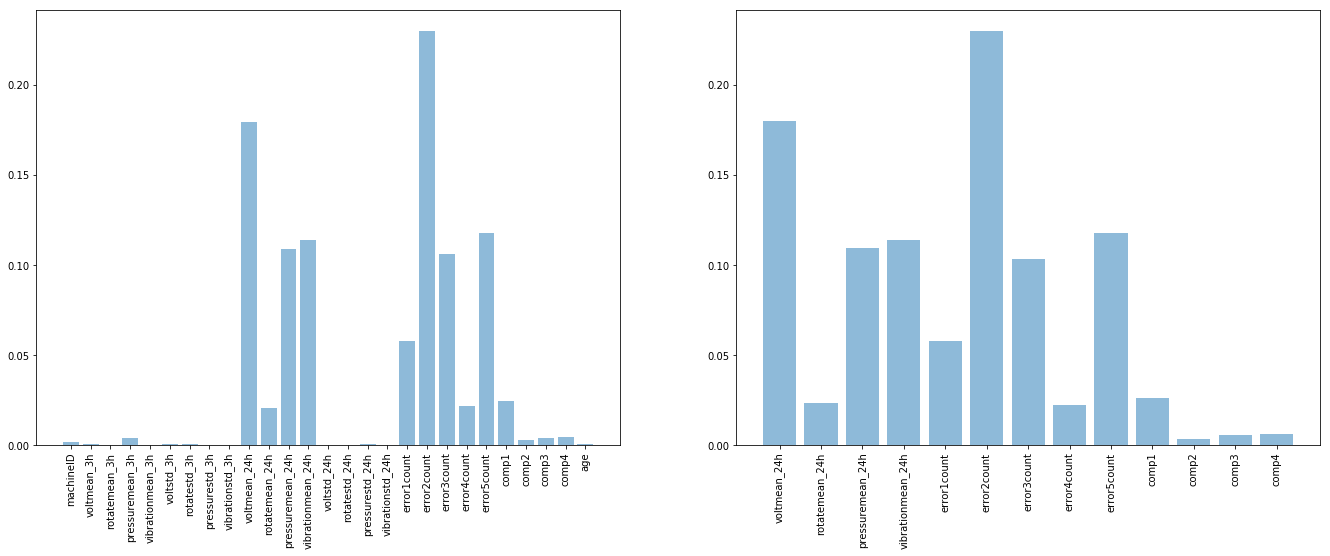

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(23,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

feat_performance_one = tree_model_one.feature_importances_
feat_performance_two = tree_model_two.feature_importances_

ax1.bar(col, feat_performance_one, align='center', alpha=0.5)
ax2.bar(col2, feat_performance_two, align='center', alpha=0.5)

ax1.set_xticklabels(col, rotation=90)
ax2.set_xticklabels(col2, rotation=90)

plt.show()

### Start Test the Prediction & Evaluation
Setelah melakukan data training, hasil dari training kita test dengan data dari split yang telah dilakukan. Di beberapa referensi, test ini bisa dikategorikan juga sebagai validasi, tetapi ada juga yang memisahkan step validasi dan test. Pada experiment saat ini kita hanya melakukan test, karena perbedaan antara test dan validasi belum dipahami dengan cukup baik.

Setelah melakukan prediksi pada phase testing, kita lakukan evaluasi kualitas dari prediksi model decision tree ini.

Dari model classification, terdapat 4 pilihan metode evaluasi:
- Quantitative Quality Indicators
- Confusion Matrix
- ROC Curve
- Lift Curve

Dalam hal ini, kita akan coba menggunakan metode Confusion Matrix dan ROC Curve.

In [27]:
tree_predict_two = tree_model_two.predict(X_test2)

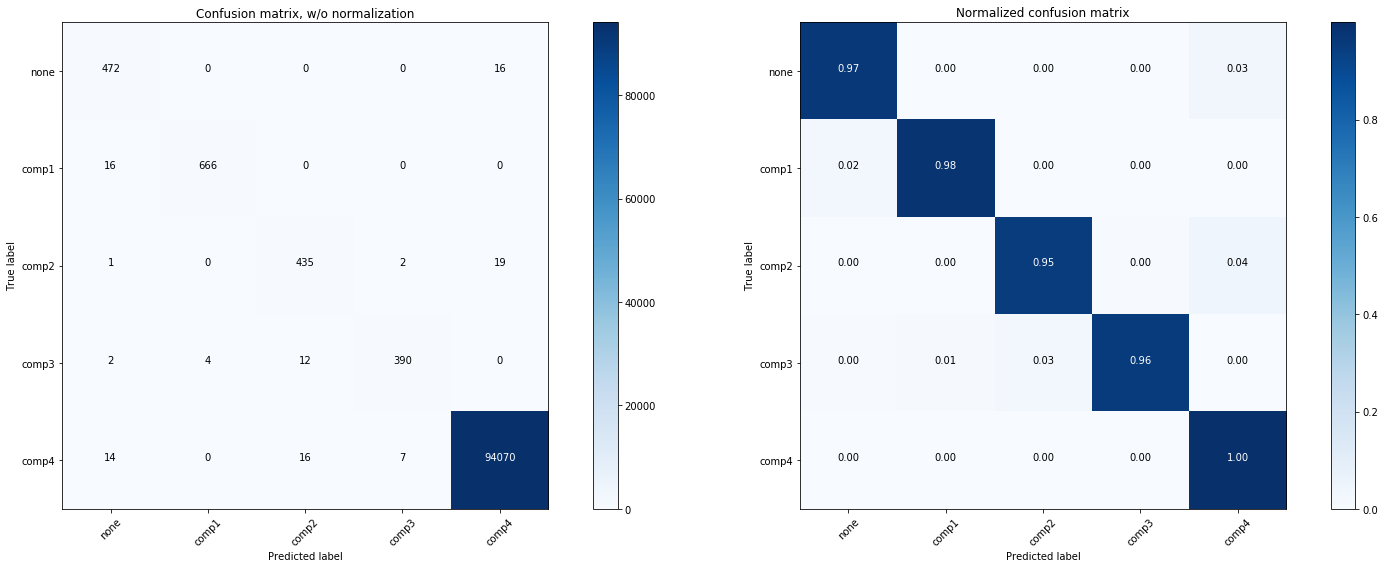

In [28]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
               color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test2, tree_predict_two)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(23,8))
ax1 = fig.add_subplot(1,2,1)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, w/o normalization')
ax2 = fig.add_subplot(1,2,2)
plot_confusion_matrix(cnf_matrix, normalize=True, classes=class_names, title='Normalized confusion matrix')

plt.show()

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, tree_predict_two))

              precision    recall  f1-score   support

       comp1       0.93      0.97      0.95       488
       comp2       0.99      0.98      0.99       682
       comp3       0.94      0.95      0.95       457
       comp4       0.98      0.96      0.97       408
        none       1.00      1.00      1.00     94107

   micro avg       1.00      1.00      1.00     96142
   macro avg       0.97      0.97      0.97     96142
weighted avg       1.00      1.00      1.00     96142

